### Import Libraries

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report
)
from sklearn.tree import plot_tree

### Import and Split Dataset

In [128]:
df = pd.read_csv('..\\data\\clean\\ordinal_encoded.csv')

X = df.drop('class_value', axis=1)
y = df['class_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_names = ['Unacceptable', 'Acceptable', 'Good', 'Very Good']
feature_names = X.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### General Purpose Methods

In [129]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive model evaluation
    """
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Add zero_division parameter to handle classes with no predictions
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Print performance metrics
    print(f"\n{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(10,7))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Return both metrics and the model
    return {
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        },
        'model': model
    }

In [ ]:
def plot_feature_importance(model, feature_names, model_name):
    plt.figure(figsize=(12,6))
    
    # Different importance extraction for different model types
    if isinstance(model, LogisticRegression):
        importances = np.abs(model.coef_).mean(axis=0) # For Logistic Regression, use absolute coefficient values
    elif isinstance(model, DecisionTreeClassifier):
        importances = model.feature_importances_       # For Decision Tree, use built-in feature importance
    elif isinstance(model, RandomForestClassifier):
        importances = model.feature_importances_       # For Random Forest, use built-in feature importance
    else:
        print(f"Feature importance not supported for {model_name}")
        return
    
    # Create feature importance plot
    indices = np.argsort(importances)
    plt.title(f'{model_name} - Feature Importances')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

## Logistic Regression

Logistic Regression Analysis:

Logistic Regression Model Performance:
Accuracy: 0.8382
Precision (Macro): 0.7218
Recall (Macro): 0.6377
F1 Score (Macro): 0.6727

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.72      0.55      0.62        77
  Acceptable       0.58      0.50      0.54        14
        Good       0.88      0.97      0.92       242
   Very Good       0.70      0.54      0.61        13

    accuracy                           0.84       346
   macro avg       0.72      0.64      0.67       346
weighted avg       0.83      0.84      0.83       346



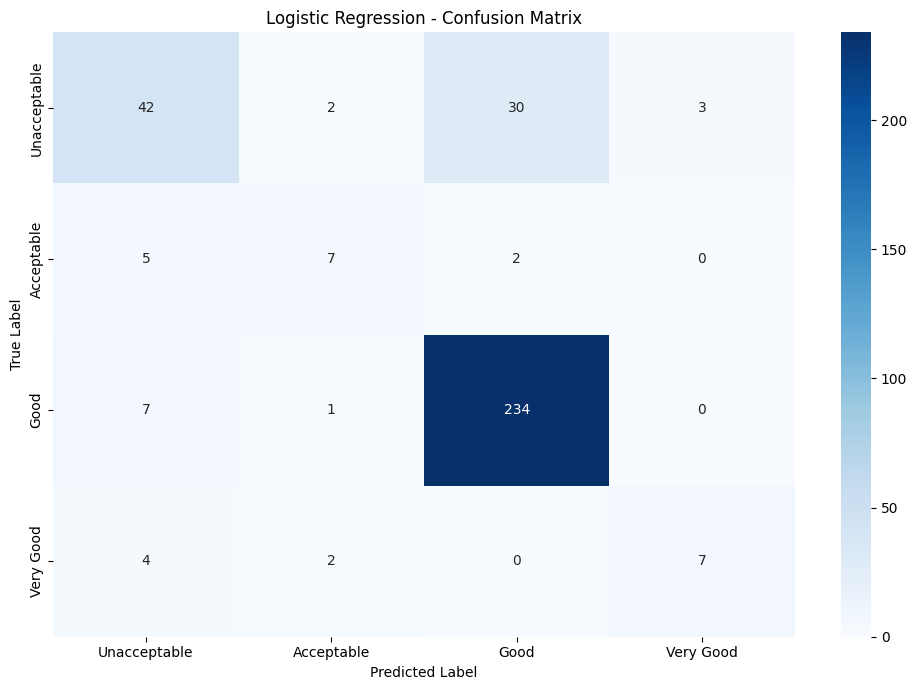

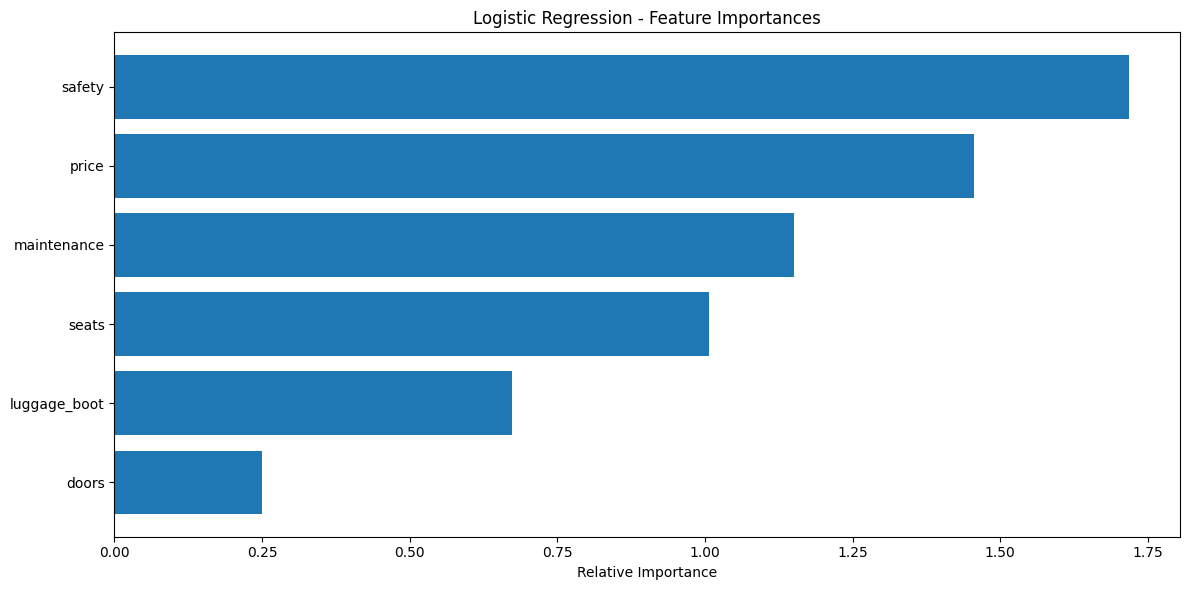

In [131]:
# Train Logistic Regression Model
lr_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000
)
lr_model.fit(X_train_scaled, y_train)

# Evaluate Logistic Regression
print("Logistic Regression Analysis:")
lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test, 'Logistic Regression')

# Plot Logistic Regression Feature Importance
plot_feature_importance(lr_model, feature_names, 'Logistic Regression')

## Decision Tree


Decision Tree Analysis:

Decision Tree Model Performance:
Accuracy: 0.8699
Precision (Macro): 0.5558
Recall (Macro): 0.6098
F1 Score (Macro): 0.5806

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.72      0.79      0.75        77
  Acceptable       0.00      0.00      0.00        14
        Good       0.94      0.95      0.95       242
   Very Good       0.56      0.69      0.62        13

    accuracy                           0.87       346
   macro avg       0.56      0.61      0.58       346
weighted avg       0.84      0.87      0.85       346



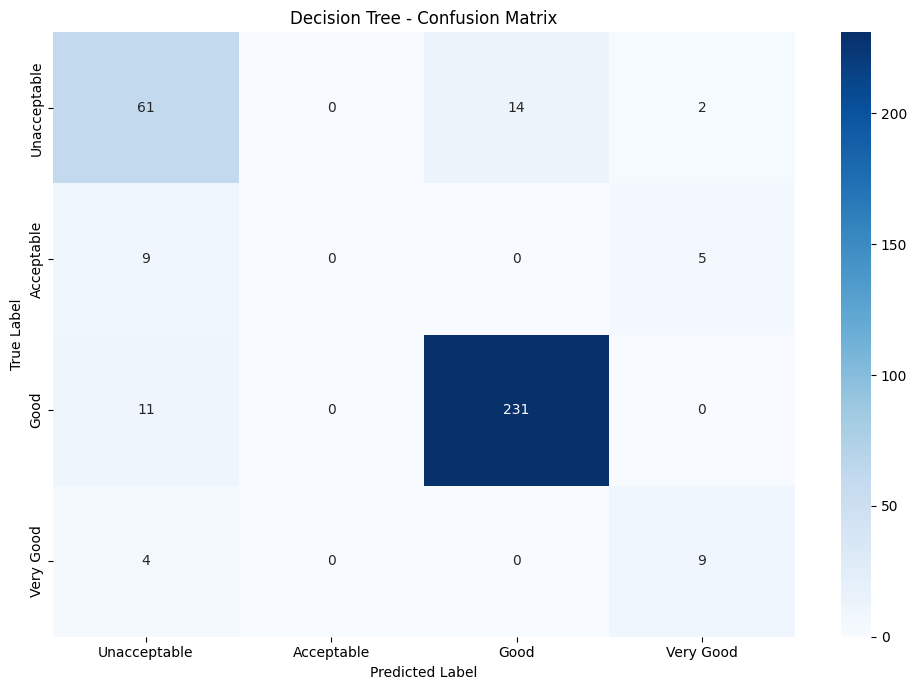

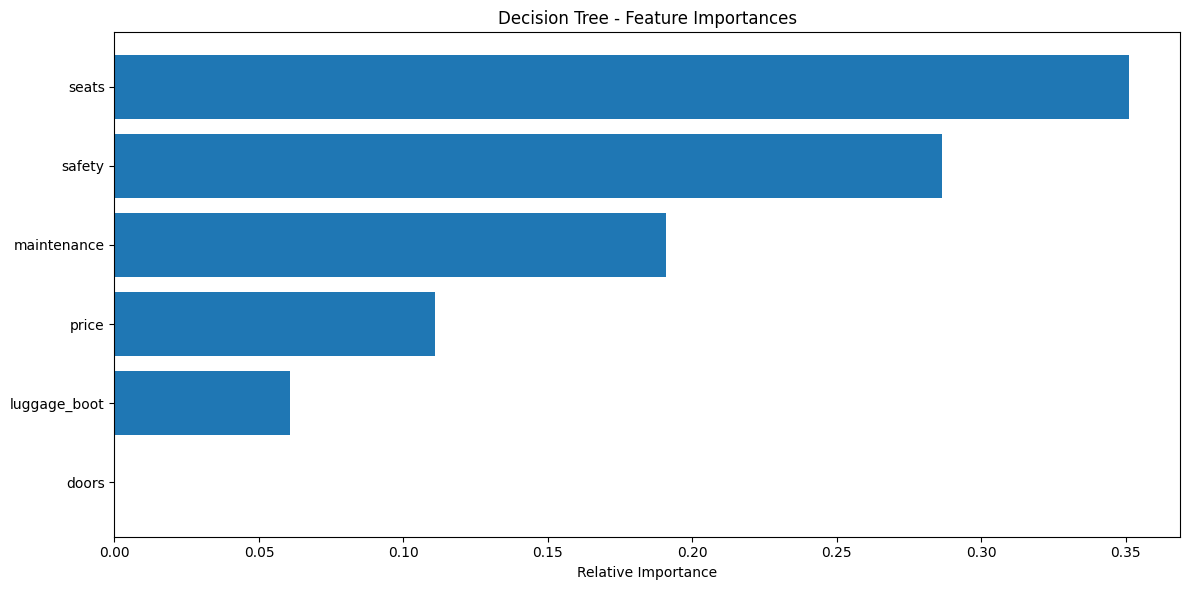

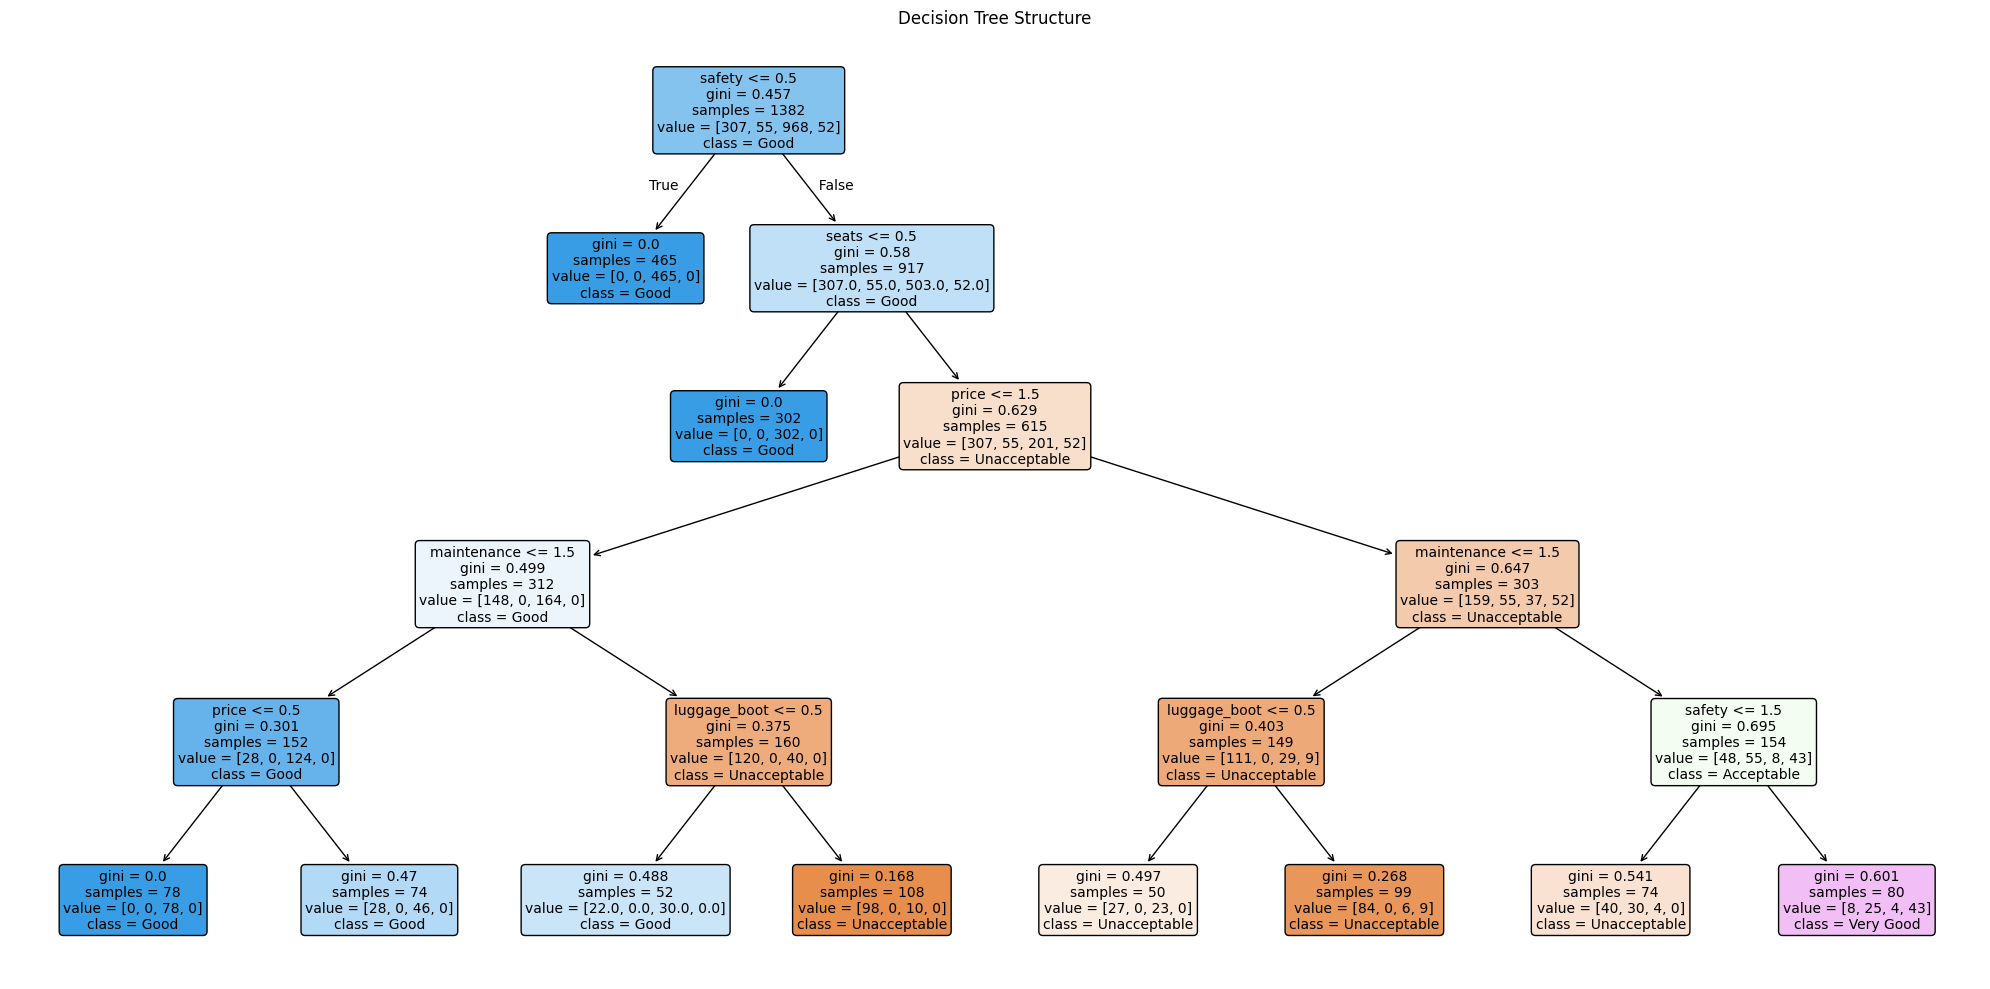

In [132]:
# Train Decision Tree Model
dt_model = DecisionTreeClassifier(
    random_state=42, 
    max_depth=5  # Prevent overfitting
)
dt_model.fit(X_train, y_train)

# Evaluate Decision Tree
print("\nDecision Tree Analysis:")
dt_metrics = evaluate_model(dt_model, X_test, y_test, 'Decision Tree')

# Plot Decision Tree Feature Importance
plot_feature_importance(dt_model, feature_names, 'Decision Tree')

# Visualize Decision Tree Structure
plt.figure(figsize=(20,10))
plot_tree(
    dt_model, 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Structure')
plt.tight_layout()
plt.show()

## Random Forest

Random Forest Analysis:

Random Forest Model Performance:
Accuracy: 0.9884
Precision (Macro): 0.9740
Recall (Macro): 0.9413
F1 Score (Macro): 0.9535

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.96      1.00      0.98        77
  Acceptable       0.93      1.00      0.97        14
        Good       1.00      1.00      1.00       242
   Very Good       1.00      0.77      0.87        13

    accuracy                           0.99       346
   macro avg       0.97      0.94      0.95       346
weighted avg       0.99      0.99      0.99       346



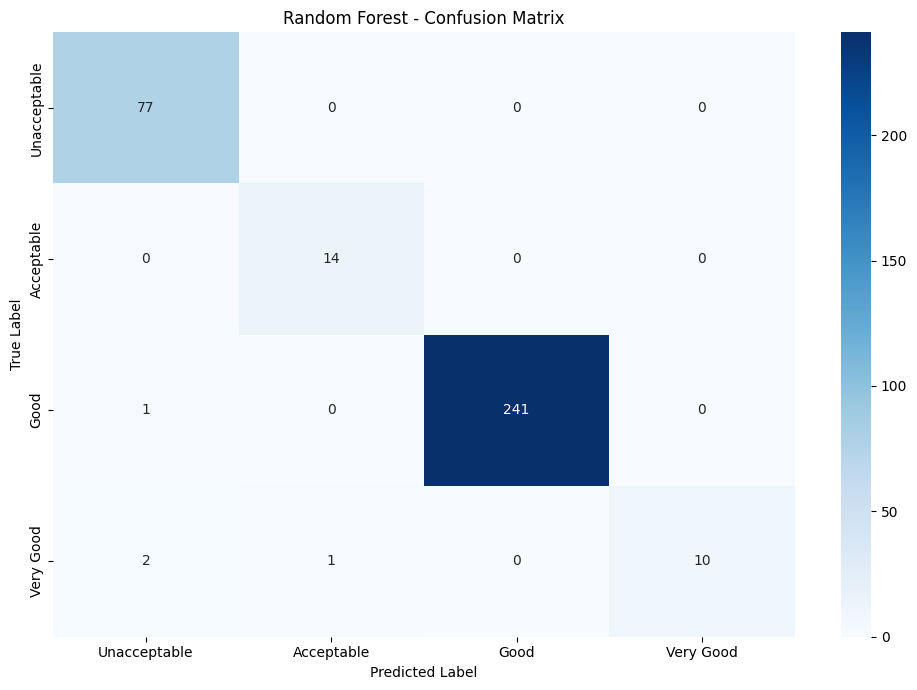

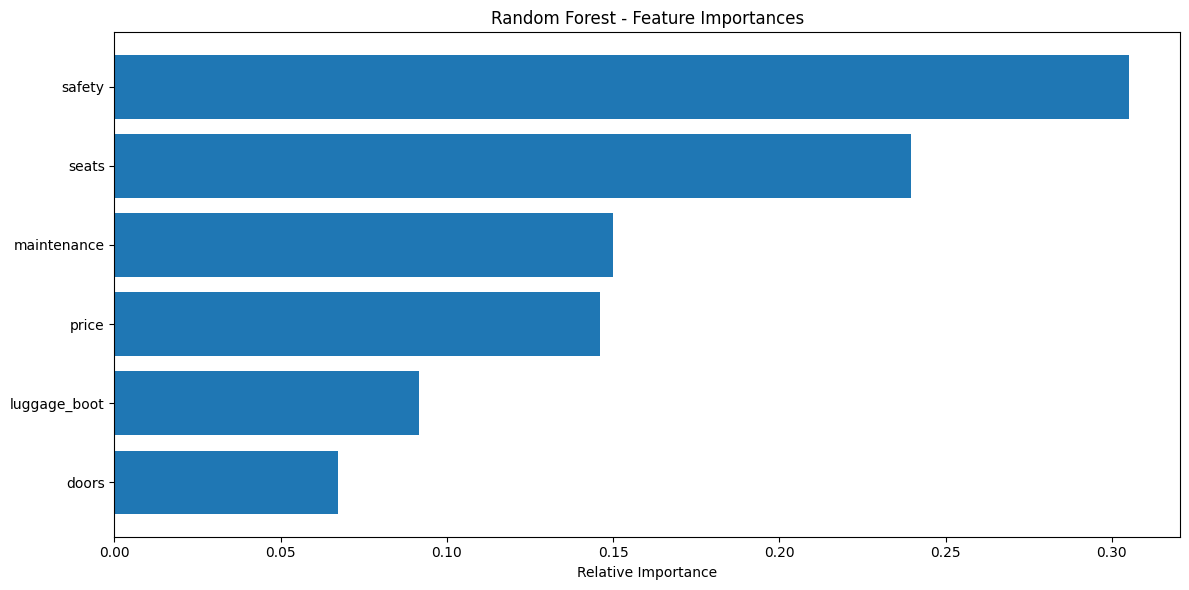

In [133]:
# Train Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    random_state=42,   # For reproducibility
    n_jobs=-1          # Use all available cores
)
rf_model.fit(X_train_scaled, y_train)

# Evaluate Random Forest
print("Random Forest Analysis:")
rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest')

# Plot Random Forest Feature Importance
plot_feature_importance(rf_model, feature_names, 'Random Forest')



## KNN

K-Nearest Neighbors Analysis:

K-Nearest Neighbors Model Performance:
Accuracy: 0.9538
Precision (Macro): 0.9370
Recall (Macro): 0.8191
F1 Score (Macro): 0.8653

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.88      0.95      0.91        77
  Acceptable       0.89      0.57      0.70        14
        Good       0.98      0.99      0.98       242
   Very Good       1.00      0.77      0.87        13

    accuracy                           0.95       346
   macro avg       0.94      0.82      0.87       346
weighted avg       0.95      0.95      0.95       346



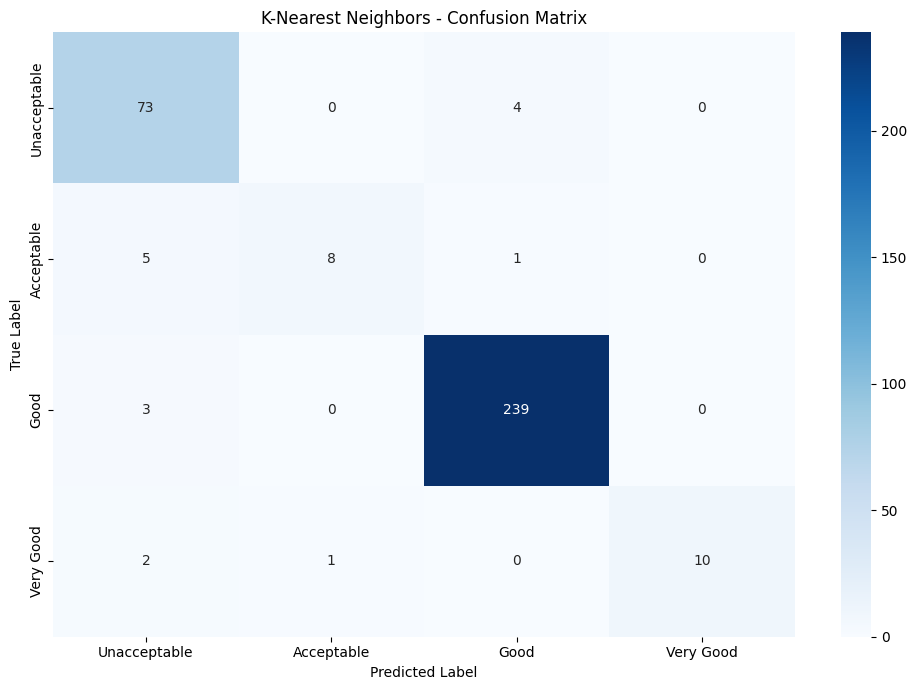

In [137]:

# Train K-Nearest Neighbors (KNN) Model
knn_model = KNeighborsClassifier(
    n_neighbors=5,     # Number of neighbors to use
    weights='uniform', # All points in each neighborhood are weighted equally
    n_jobs=-1          # Use all available cores
)
knn_model.fit(X_train_scaled, y_train)

# Evaluate KNN
print("K-Nearest Neighbors Analysis:")
knn_metrics = evaluate_model(knn_model, X_test_scaled, y_test, 'K-Nearest Neighbors')

## Gradient Boosting


Gradient Boosting Analysis:

Gradient Boosting Model Performance:
Accuracy: 0.9913
Precision (Macro): 0.9906
Recall (Macro): 0.9969
F1 Score (Macro): 0.9937

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.96      1.00      0.98        77
  Acceptable       1.00      1.00      1.00        14
        Good       1.00      0.99      0.99       242
   Very Good       1.00      1.00      1.00        13

    accuracy                           0.99       346
   macro avg       0.99      1.00      0.99       346
weighted avg       0.99      0.99      0.99       346



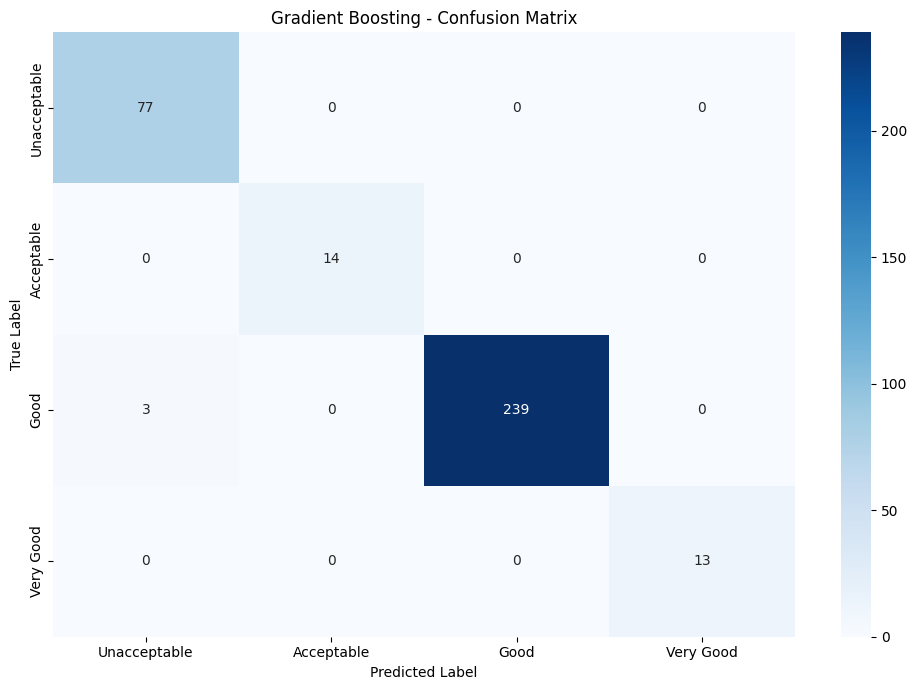

Feature importance not supported for Gradient Boosting


<Figure size 1200x600 with 0 Axes>

In [136]:
# Train Gradient Boosting Model
gb_model = GradientBoostingClassifier(
    n_estimators=100,    # Number of boosting stages
    learning_rate=0.1,   # Shrinks the contribution of each tree
    max_depth=3,         # Maximum depth of individual trees
    random_state=42      # For reproducibility
)
gb_model.fit(X_train_scaled, y_train)

# Evaluate Gradient Boosting
print("\nGradient Boosting Analysis:")
gb_metrics = evaluate_model(gb_model, X_test_scaled, y_test, 'Gradient Boosting')

# Plot Gradient Boosting Feature Importance
plot_feature_importance(gb_model, feature_names, 'Gradient Boosting')

## Support Vector Classifier


Support Vector Classifier Analysis:

Support Vector Classifier Model Performance:
Accuracy: 0.9740
Precision (Macro): 0.9766
Recall (Macro): 0.9513
F1 Score (Macro): 0.9630

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.91      0.97      0.94        77
  Acceptable       1.00      0.93      0.96        14
        Good       0.99      0.98      0.99       242
   Very Good       1.00      0.92      0.96        13

    accuracy                           0.97       346
   macro avg       0.98      0.95      0.96       346
weighted avg       0.98      0.97      0.97       346



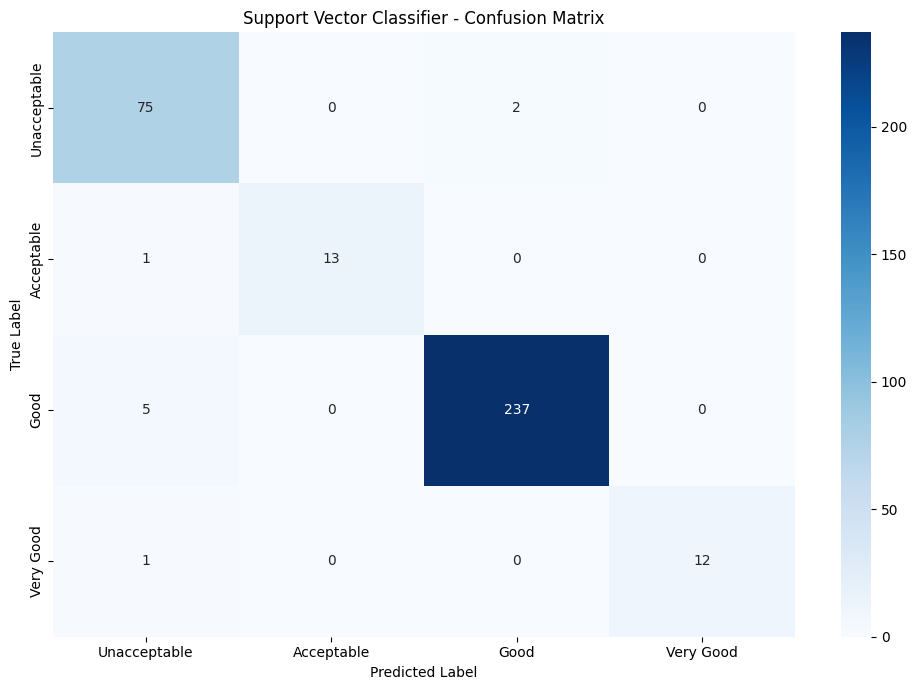

In [140]:
# Train Support Vector Classifier
svc_model = SVC(
    kernel='rbf',        # Radial Basis Function kernel
    C=1.0,               # Regularization parameter
    random_state=42      # For reproducibility
)
svc_model.fit(X_train_scaled, y_train)

# Evaluate Support Vector Classifier
print("\nSupport Vector Classifier Analysis:")
svc_metrics = evaluate_model(svc_model, X_test_scaled, y_test, 'Support Vector Classifier')
